<img src='img/banner.png' align='right' width='100%'></img>

<div class="alert alert-block alert-success">
<b>PREREQUISITE </b><br>
    
For a smooth experience, some actions are needed:
* It is expected for the user to be familiar with Python.
* It is expected, that **MSG MDFVC** product data is saved locally. Download it from [LSA SAF data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MDFVC/NETCDF/) in `NetCDF4` format for the following period: November 1, 2015 to November 30, 2023.
* It is expected, that **MSG FRP - Pixel** product data is downloaded from [LSA SAF data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MDFVC/NETCDF/) in `HDF5` format for the dates between June 17, 2017 and July 17, 2017 and in the period between July 7, 2022 and September 5, 2022.
</div>



<hr>

# Analysing the  Effects of Wild Fires on Vegetation Using LSA SAF MSG MDFVC Product and LSA SAF MSG-FRP Pixel Product

#### About

South Europe is prone to the occurrence of large wildfires that have serious impacts at the socio-economic and ecological levels. 
The Mediterranean climate, characterized by hot, dry summers and mild, wet winters, creates favorable conditions for the outbreak and rapid spread of fires, exacerbated by factors such as drought, high temperatures, and strong winds. Therefore a reliable detection of fires as well as an estimation of their severity and impact is of great importance when addressing the risk posed by wildfires.

The aim of this Jupyter Notebook (JN) is to analyse the released power and evolution of the 3 major wildfires in the years 2017 and 2022 and their effect on vegetation. Firstly LSA SAF Fire Radiative Power Pixel Product (FRP) [LSA SAF FRPPIXEL [502]](https://landsaf.ipma.pt/en/data/products/fire-products/) was used to calculate the total released firepower of the fires. Then [LSA SAF MDFVC [421]](https://landsaf.ipma.pt/en/data/products/vegetation/) product was used to detect potential impacts on vegetation since FVC is a good measure for the state of the vegetation.

#### How to Access the Data

For this example, MDFVC measurements from November 1, 2015 to November 30, 2023 and FRP - Pixel Product from June 17, 2017 to July 17, 2017 and from July 7, 2022 to September 5, 2022. MDFVC is available as `NetCDF4` as well as `HDF5` files and FRP -Pixel Product only in `HDF5`. `NetCDF4`files will be used with the MDFVC product and `HDF5` files with FRP - Pixel Product. The LSA SAF products files can be downloaded from the [data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/) available at https://datalsasaf.lsasvcs.ipma.pt/ with prior registration.

Data can be downloaded in various ways, for instance manually, using approach published on [lsasaf_data_access GitLab](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/blob/main/examples/webdav/webdav_colab_example.ipynb) repository or using [WebDAV protocol](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/webdav). An additional option is to use the `GNU Wget` program.

#### Basic facts on the LSA SAF MDFVC
> **Product number**: LSA-421
>
> **Spatial resolution**: 3km at nadir
> 
> **Spatial coverage**: MSG-Disk
> 
> **Time steps**: 1 day
> 
> **Data availability**: from 2016
>

#### Basic facts on the LSA SAF FRP - Pixel Product
> **Product number**: LSA-502
>
> **Spatial resolution**: 3km at nadir
> 
> **Spatial coverage**: MSG-Disk
> 
> **Time steps**: 15 min
> 
> **Data availability**: from 2016
> 


#### Module outline:
* [1 - Accessing the Data](#First)
* [2 - Analysing the Effect of Wildfire on the FVC](#Second)
* [3 - Plotting](#Third)

<hr>

#### Load required libraries

In [1]:
import h5py                           # a library for working with HDF5 file formats.
import numpy as np                    # a library that lets us work with arrays; we import this with a new name "np"
import pandas as pd                   # a library for time series analysis
import datetime as dt                 # a library that allows us to work with dates and times
import xarray as xr                   # a library that helps us work efficiently with multi-dimensional arrays
import matplotlib.pyplot as plt       # a library the provides plotting capability
from tqdm import tqdm                 # a library to display progress meter with low overhead

#### Defining Utility Functions

In this section, we will define multiple functions that will be used throughout this JN.

LSA SAF product files are named with a rather complex naming convention. Therefore we define functions `HDF5_FRP_name()` and `NETCDF4_FVC_name()` functions, that return the name of the FRP-PIXEL product and MDFVC product at a given time. The `HDF5_FRP_name()` returns the name of the `HDF5` file, since the FPR product is only available in this format, while the `NETCDF4_FVC_name()` returns the name of the `NetCDF4` file.

In [2]:
def HDF5_FRP_name(time):
    '''
    Returns the name of LSA SAF MSG FRP List Pixel product
    HDF5 file from particular day and time.
    '''
    HDF5_name=FRP_LOCATION+"HDF5_LSASAF_MSG_FRP-PIXEL-ListProduct_MSG-Disk_"+time.strftime('%Y%m%d%H%M')
    return HDF5_name

In [3]:
def NETCDF4_FVC_name(time):
    '''
    Returns the name of LSA SAF MSG FVC product
    NetCDF4 file from particular day and time.
    '''
    NetCDF4_name=FVC_LOCATION+"NETCDF4_LSASAF_MSG_FVC_MSG-Disk_"+time.strftime('%Y%m%d%H%M')+".nc"
    return NetCDF4_name

<a name="get_HDF5_FRP_data"></a>
In the next step, we will define the function `get_HDF5_FRP_data()`. This function opens the FRP product in `HDF5` format and exports its content as a `pandas.DatFrame`. Accessing and opening `HDF5` files is achieved by the `h5py` library.

`HDF5` file types consist of multiple datasets. In the case of FRP products, it is a list of all pixels in which, the fire was detected, together with the properties of the detected fire (e.g. firepower), as well as some other attributes. To specify, which dataset within the `HDF5` file to access one needs to specify `dataset_names`; a list of wanted dataset names.

In [4]:
def get_HDF5_FRP_data(HDF5_filename, dataset_names):
    '''
    This function returns 1D Datasets of HDF5 file as a pd. dataframe
    '''
    # Create empty pd dataframe
    df=pd.DataFrame()

    # Load HDF5 file
    file=h5py.File(HDF5_filename, 'r')


    #Loop over datasets of the interest
    for i in range(len(dataset_names)):
        dset=file[dataset_names[i]]
        df[dataset_names[i]]=dset[:]*(1/dset.attrs["SCALING_FACTOR"])

    return df

We will also define the `calculate_total_FRP()` function, which estimates the total FRP within a specified lat-lon rectangle at the time of the interest. Function calls `get_HDF5_FRP_data()` function and extracts the data about pixel with active fires if any. This data includes FRP, FRP uncertainty, latitude and longitude. Consequently, the pixels outside the lat-lon square are filtered and the FRP values of all remaining pixels are summed to obtain the total FRP inside the specified area.

In [5]:
def calculate_total_FRP(date, lat_min, lat_max, lon_min, lon_max):
    '''
    Function calculates total fire radiation power inside rectangle
    (lat_min-lat_max x lon_min-lon_max). 
    date=pd.datetime object
    output=Total FRP [MW]
    '''
    # Get a dataset of all pixels with active fire
    FRP_dataset=get_HDF5_FRP_data(HDF5_FRP_name(date), ["FRP", "FRP_UNCERTAINTY", "LATITUDE", "LONGITUDE"])

    # Drop entries with lat outside the range
    FRP_dataset=FRP_dataset[(FRP_dataset['LATITUDE'] > lat_min) & (FRP_dataset['LATITUDE'] < lat_max)]

    # Drop entries with lon outside the range
    FRP_dataset=FRP_dataset[(FRP_dataset['LONGITUDE'] > lon_min) & (FRP_dataset['LONGITUDE'] < lon_max)]
    
    # Sum all remaining FRP walues to get total FRP
    total_FRP=np.sum(FRP_dataset["FRP"].to_numpy())
    
    return(total_FRP)

<a name="calculate_average_FVC"></a>
We define the function `calculate_average_FVC()` which calculates the average value of FVC over the specified lat-lon rectangle. MDFVC product is available in both `HDF5` and `NetCDF4` format, the latter is used here. The function `calculate_average_FVC()` uses the `xarray` library, to select only the area within the lat-lon rectangle using the `sel()` method and to export values to `numpy`. The `numpy.nanmean()` is then used to calculate the average value.

In [6]:
def calculate_average_FVC(date, lat_min, lat_max, lon_min, lon_max):
    '''
    Function calculates average FVC over rectangle (lat_min-lat_max x lon_min-lon_max).
    It ignores NaN walues.
    date=pd.datetime object
    output=average FVC
    '''
    FVC_ds=xr.open_dataset(NETCDF4_FVC_name(date))
    FVC_ds=FVC_ds.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))["FVC"].load()
    FVC_np=FVC_ds.values[0,:,:]
    avg_FVC=np.nanmean(FVC_np)

    FVC_ds.close()
    return avg_FVC

<a name="analyse_fire"></a>
In this JN the Wildfires will be investigated by comparing the FVC before and after the wildfire and at the same time investigating the total FRP in the affected area. To automate this step a `analyse_fire()` function will be defined. It returns the average FVC, and total FRP values over the specified area as a time series. To detect the effects of the fire on the FVC, a longer interval needs to be observed, a default of a year before and after the fire. This is long compared to the actual duration, typically a couple of weeks (in the function default is set to 30 days). This was the reason to output the FRP and FC values together with the list of dates, for which they were evaluated., by the `analyse_fire()` function.

When using the `analyse_fire()` function it is recommended to track potential errors, e.g. missing files, by setting the `SHOW_ERRORS` global variable to `True`. In this example, it is omitted, since quite some FRP files are missing and the print of errors is too long.

In [7]:
SHOW_ERRORS=False

In [8]:
def analyse_fire(fire_start_date, lat_min, lat_max, lon_min, lon_max, fire_duration=30, FVC_time_before=365, FVC_time_after=365):
    '''
    Retunrs values of total FVC in the area and average FVC in the area.
    As default it returns FRP from start date for 30 days.
    As default it returns FVC value a year before and after the fire
    It returns "daycount": a number of days from the beggining of fire (negative before the start of fire)
    '''
    # We define FVC daterange and daycount (day 0 = start of the fire)
    FVC_datarange=pd.date_range(fire_start_date-dt.timedelta(days=FVC_time_before),fire_start_date+dt.timedelta(days=FVC_time_after),freq='1D', inclusive="left")
    FVC_daycount=np.arange(-FVC_time_before, FVC_time_after, 1)
    FVC_output=np.full(len(FVC_datarange), np.nan)

    # We define FRP daterange and daycount (day 0 = start of the fire)
    FRP_datarange=pd.date_range(fire_start_date,fire_start_date+dt.timedelta(days=fire_duration),freq='15T', inclusive="left")
    FRP_daycount=np.arange(0, fire_duration, 1/96)
    FRP_output=np.full(len(FRP_datarange), np.nan)

    # Loop over FVC data
    for i in tqdm(range(len(FVC_datarange))):
        try:
            FVC_output[i]=calculate_average_FVC(FVC_datarange[i],lat_min, lat_max, lon_min, lon_max)
        except:
            if SHOW_ERRORS:
                print("Problem with FVC value for the date: " +str(FVC_datarange[i]))

    #Loop over FRP data
    for i in tqdm(range(len(FRP_datarange))):
        try:
            FRP_output[i]=calculate_total_FRP(FRP_datarange[i],lat_min, lat_max, lon_min, lon_max)
        except:
            if SHOW_ERRORS:
                print("Problem with FRP value for the date: " +str(FRP_datarange[i]))

    # Set output
    return FVC_daycount, FVC_output, FRP_daycount, FRP_output
            

### <a id='First'></a>1. Accessing the Data

All the necessary data need to be downloaded before running this JN. We first specify the path to the MDFVC and FRP - PIXEL products as 2 global variables `FRP_LOCATION` and `FVC_LOCATION`.

In [9]:
FRP_LOCATION="Data_FRP/"
FVC_LOCATION="Data_FVC/"

LSA SAF MDFVC is available daily in two file formats `HDF5` and `NetCDF4`, while the FRP-Pixel List Product is only available as an `HDF5` file. The `NetCDF4` files can be manipulated directly in the Python library `xarray` while accessing and opening `HDF5` files is achieved by using the `h5py` library.

FRP List Product in  `HDF5` format is a group of datasets, fully described in the FRP Pixel product Product User Manual available [here](https://nextcloud.lsasvcs.ipma.pt/s/TjpsBziZFNN6GPN). The internal structure of the `HDF5` file can be investigated using `h5py` or with appropriate software for instance [HDFView](https://www.hdfgroup.org/downloads/hdfview/) or an online tool [myHDF5](https://myhdf5.hdfgroup.org/), which doesn't require installation.

The accessing of the `HDF5` files in this JN will be done by the usage of [`get_HDF5_FRP_data()`](#get_HDF5_FRP_data) function.

The MDFVC product is available in `NetCDF4`, format and can be easily accessed by the usage of the `xarray` library. in this JN we will access MDFVC measurements using the predefined [`calculate_average_FVC`](#calculate_average_FVC) function.

### <a id='Second'></a>2. Analysing the Effect of Wildfire on the FVC

In this JN we will compare FVC on the wildfire-affected area before and after the fire, but the info about the affected area won't be retrieved from the LSA SAF products but rather from the external source.

Data about wildfires will be extracted from FRP product. Due to relatively large pixels, it is not the most accurate product to provide an estimate of the burnt area, compared to similar products based on the satellites in the lover orbit. Contrary, it allows really good insight into the time evolution of wildifre since FRP List Product is provided in real-time, every 15 min. 

In this case [Copernicus Emergency Management Service - Mapping](https://emergency.copernicus.eu/mapping/copernicus-emergency-management-service#zoom=2&lat=13.56036&lon=33.82273&layers=00B0T) was used as an external source of the info about the affected area.

The exact dates of the wildfires were retrieved from the [European Forest Fire Information System - EFFIS](https://effis.jrc.ec.europa.eu/). The start dates and locations are hard-coded in the following cell.

The 3 Wildfires will be investigated:
* The wildfire in Pedroago, Portugal which started on June 17,  2017, resulted in 66 deaths and approximately 50 000 ha of burnt area,
* The wildfire in the Kras region, Slovenia, which started on July 21, 2022, resulted in 2000 ha of burnt area.
* The wildfire in Covilhã, Portugal, which started on August 6, 2022, resulted in 4000 ha of burnt area.

In the next cell, we will extract FVC values from 600 days before to 365 days after the wildfire and FRP values for 30 days since the start of the fire. The extraction of booth data will be done by calling the [`analyse_fire()`](#analyse_fire) function, defined at the beginning of this JN.

As input parameters to [`analyse_fire()`](analyse_fire) we need to specify, the start date of the fire and a lat-lon rectangle, which includes the whole area, affected by the wildfire. A total FRP in this area is then calculated within the `analyse_fire()` function by the `calculate_total_FRP()` function, and average FVC in the lat-lon rectangle by the `calculate_average_FVC()` within analyse fire.

In [ ]:
# Pedrogao
pedrogao_start_date=dt.datetime(2017, 6, 17, 0, 0, 0)
pedrogao_coordinates=[39.75, 40.25, -8.75, -7.5]
pedrogao_x_FVC, pedrogao_y_FVC, pedrogao_x_FRP, pedrogao_y_FRP=analyse_fire(
    pedrogao_start_date,
    pedrogao_coordinates[0],
    pedrogao_coordinates[1],
    pedrogao_coordinates[2],
    pedrogao_coordinates[3],
    FVC_time_before=600
    )

# Kras wildfire
kras_start_date=dt.datetime(2022, 7, 21, 0, 0, 0)
kras_coordinates=[45.7, 46.0, 13.5, 13.9]
kras_x_FVC, kras_y_FVC, kras_x_FRP, kras_y_FRP=analyse_fire(
    kras_start_date,
    kras_coordinates[0],
    kras_coordinates[1],
    kras_coordinates[2],
    kras_coordinates[3],
    FVC_time_before=600
    )

# Covilha wildfire
covilha_start_date=dt.datetime(2022,8,6,0,0,0)
covilha_coordinates=[40.2, 40.7, -7.7, -7.1]
covilha_x_FVC, covilha_y_FVC, covilha_x_FRP, covilha_y_FRP=analyse_fire(
    covilha_start_date,
    covilha_coordinates[0],
    covilha_coordinates[1],
    covilha_coordinates[2],
    covilha_coordinates[3],
    FVC_time_before=600
    )

### <a id='Third'></a>3. Plotting

We can now prepare a plot for wildfire in Pedrogao, Portugal. We want to analyse how the FVC changes (decreases during the forest fire). Since the Pedrogao fire was the biggest of the 3 mentioned here, the effect on vegetation is the most visible.

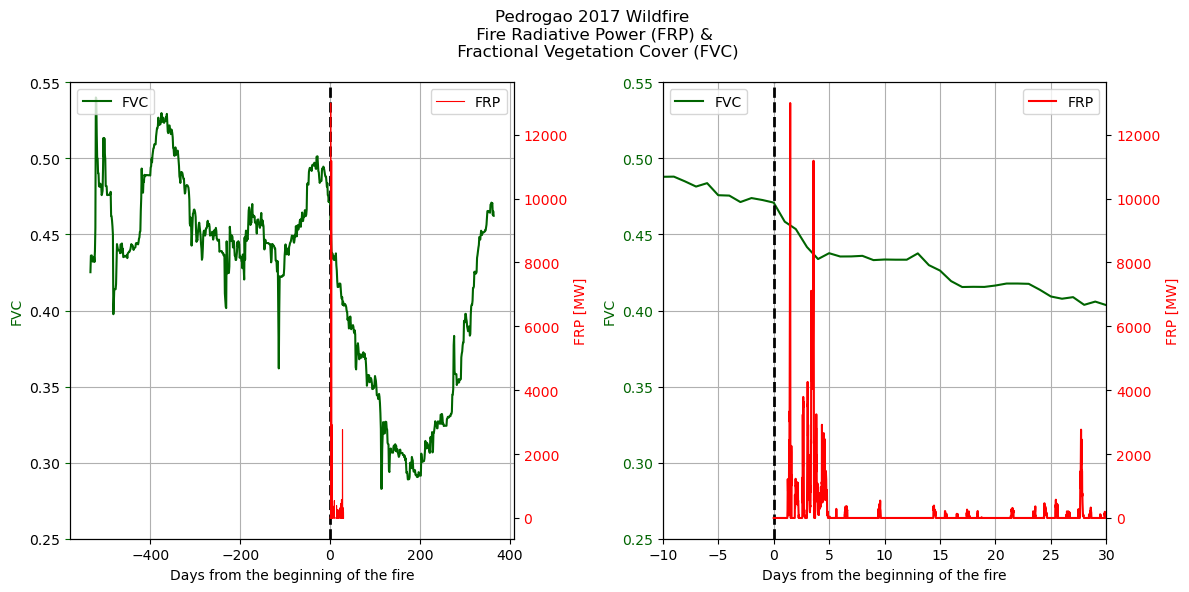

In [11]:
# Define plot colors
FVC_color="darkgreen"
FRP_color="red"

# Create figure and axes objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot data on the first subplot
ax1.plot(pedrogao_x_FVC, pedrogao_y_FVC, FVC_color, label='FVC')
ax1.set_ylabel('FVC', color=FVC_color)
ax1.set_ylim(0.25, 0.55)
ax1.tick_params(axis='y', color=FVC_color)

ax1_2 = ax1.twinx()
ax1_2.plot(pedrogao_x_FRP, pedrogao_y_FRP, FRP_color, label='FRP', linewidth=0.8)
ax1_2.set_ylabel('FRP [MW]', color=FRP_color)
ax1_2.tick_params(axis='y', labelcolor=FRP_color)


# Plot data on the second subplot
ax2.plot(pedrogao_x_FVC, pedrogao_y_FVC, FVC_color, label='FVC')
ax2.set_ylabel('FVC', color=FVC_color)
ax2.set_ylim(0.25, 0.55)
ax2.tick_params(axis='y', labelcolor=FVC_color)

ax2_2 = ax2.twinx()
ax2_2.plot(pedrogao_x_FRP, pedrogao_y_FRP, FRP_color, label='FRP')
ax2_2.set_ylabel('FRP [MW]', color=FRP_color)
ax2_2.tick_params(axis='y', labelcolor=FRP_color)


# Set the first subplot
ax1.set_xlabel('Days from the beginning of the fire')
ax1.axvline(x=0, linestyle='dashed', color="black", linewidth=2)
ax1.axhline(y=0, linestyle='dashed', color="grey")
ax1.grid(True)

# Set the second sublot
ax2.set_xlim(-10, 30)
ax2.set_xlabel('Days from the beginning of the fire')
ax2.axvline(x=0, linestyle='dashed', color="black", linewidth=2)
ax2.axhline(y=0, linestyle='dashed', color="grey")
ax2.grid(True)

# Display legends
ax1.legend(loc='upper left')
ax1_2.legend(loc='upper right')
ax2.legend(loc='upper left')
ax2_2.legend(loc='upper right')


plt.suptitle('Pedrogao 2017 Wildfire \n Fire Radiative Power (FRP) & \n Fractional Vegetation Cover (FVC)')
plt.tight_layout()
plt.show()

We can clearly see, that the FVC decreased from approximately 0.47 to approximately 0.44 in the range of 5 days when the fire was burning. Furthermore, it can be detected, that the FVC reaches smaller values in a year after the fire, compared to the previous year.

But this decline of FVC based on the MSG satellite is so clear only in the case of the bigger fires, such as in the Pedrogao wildfire. The decrease in FVC is much smaller in the case of the fires in Kras and Covilhã. All 3 wildfires are plotted in a similar manner as in the previous code cell in the following plot:

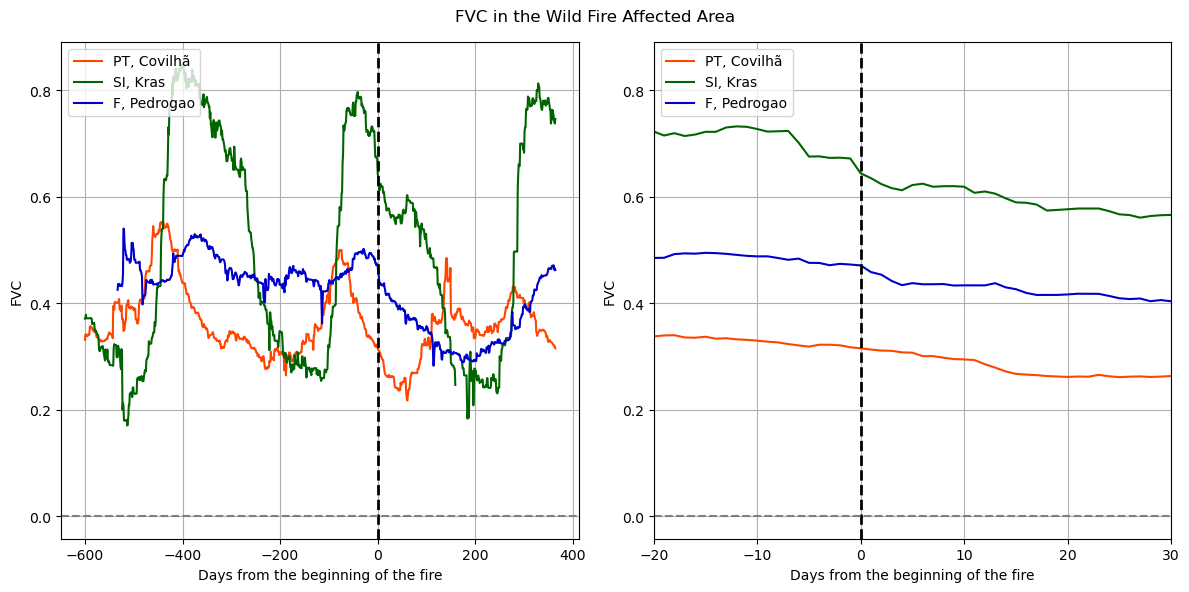

In [12]:
# Define plot colors
FVC_color="darkgreen"
FRP_color="red"

# Create figure and axes objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

FVC_color="darkgreen"
FRP_color="red"



# First subplot
ax1.plot(covilha_x_FVC, covilha_y_FVC, label='PT, Covilhã', color="orangered")
ax1.plot(kras_x_FVC, kras_y_FVC, label="SI, Kras", color='darkgreen')
ax1.plot(pedrogao_x_FVC, pedrogao_y_FVC, label="F, Pedrogao", color='mediumblue')

#Second subplot
ax2.plot(covilha_x_FVC, covilha_y_FVC, label='PT, Covilhã', color="orangered")
ax2.plot(kras_x_FVC, kras_y_FVC, label="SI, Kras", color='darkgreen')
ax2.plot(pedrogao_x_FVC, pedrogao_y_FVC, label="F, Pedrogao", color='mediumblue')
ax2.set_xlim(-20, 30)

# Set the first subplot
ax1.set_ylabel('FVC')
ax1.set_xlabel('Days from the beginning of the fire')
ax1.axvline(x=0, linestyle='dashed', color="black", linewidth=2)
ax1.axhline(y=0, linestyle='dashed', color="grey")
ax1.grid(True)

# Set the second subplot
ax2.set_ylabel('FVC')
ax2.set_xlabel('Days from the beginning of the fire')
ax2.axvline(x=0, linestyle='dashed', color="black", linewidth=2)
ax2.axhline(y=0, linestyle='dashed', color="grey")
ax2.grid(True)

# Display legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.suptitle("FVC in the Wild Fire Affected Area")
plt.tight_layout()
plt.show()

#### Conclusion

We show the behavior of FVC after the outbreak of the three major wildfires in the period from 2017 to 2022 in Europe. Fire radiative power is used to determine the severity and the time of a wildfire outbreak.
The evolution of the fraction of vegetation cover is monitored in the period before and after ignition. For the fire in Pedrogao, the decreased values of FVC can be observed even in the following years.

#### References:

* array Developers (2023). xarray User Guide. [https://docs.xarray.dev/en/stable/user-guide/index.html](https://docs.xarray.dev/en/stable/user-guide/index.html). Accesed: 23.2.2025
* Ribeiro, L.M., Rodrigues, A., Lucas, D. et. al. (2020) The Impact on Structures of the Pedrógão Grande Fire Complex in June 2017 (Portugal), Fire 2020, 3, 57. [doi:10.3390/fire3040057](https://doi.org/10.3390/fire3040057 )
* Slovenian Government (2022) Poročilo o ukrepanju in intervencijskih stroških gašenja požara v naravnem okolju na območju Krasa od 17. julija do 1. avgusta 2022. [http://vrs-3.vlada.si/MANDAT22/vladnagradiva.nsf/71d4985ffda5de89c12572c3003716c4/8a691ba86ac2ada4c12588c6002df3eb?OpenDocument](http://vrs-3.vlada.si/MANDAT22/vladnagradiva.nsf/71d4985ffda5de89c12572c3003716c4/8a691ba86ac2ada4c12588c6002df3eb?OpenDocument). Accesed: 23.2.2025